# ALGEBRA

In [0]:
%fs ls dbfs:/FileStore/tables/tmp/EAFIT/ds/cleaned

path,name,size,modificationTime
dbfs:/FileStore/tables/tmp/EAFIT/ds/cleaned/_SUCCESS,_SUCCESS,0,1669256910000
dbfs:/FileStore/tables/tmp/EAFIT/ds/cleaned/_committed_1132244810132789727,_committed_1132244810132789727,112,1669256909000
dbfs:/FileStore/tables/tmp/EAFIT/ds/cleaned/_started_1132244810132789727,_started_1132244810132789727,0,1669256905000
dbfs:/FileStore/tables/tmp/EAFIT/ds/cleaned/part-00000-tid-1132244810132789727-962c4a0b-1072-446b-a430-7a224b7bd2e6-86-1-c000.csv,part-00000-tid-1132244810132789727-962c4a0b-1072-446b-a430-7a224b7bd2e6-86-1-c000.csv,876102,1669256908000


In [0]:
%pip install factor_analyzer

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
%pip install statsmodels

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
from pyspark.sql.types import *
import pyspark.sql.functions as F

from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_kmo
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [0]:
full_data = (spark
             .read
             .format("csv")
             .option("header", "true")
             .option("inferSchema", "true")
             .load("s3://datalake-ds-project/data/transformed/cleaned/ein_full_data_irs990")
            )

display(full_data)

prior_year_invest_income,curr_year_invest_income,crr_year_other_revenue,prior_year_other_revenue,prior_year_total_revenue,curr_year_total_revenue,curr_year_grants_amount,prior_year_grants_amount,curr_year_members_benef_payment,prior_year_members_benef_payment,prior_year_salaries,curr_year_salaries,curr_year_other_exp,prior_year_total_exp,prior_year_other_exp,curr_year_total_exp,prior_year_rev_less_exp,curr_year_rev_less_exp,curr_year_contrib_grants,prior_year_contrib_grants,curr_year_program_serv_revenue,prior_year_program_serv_revenue,ein
9689,4877,3768,20822,3968966,2110896,26957,42420,0,0,1789044,1772087,1470894,3696646,1865182,3269938,272320,-1159042,1911190,3686162,191061,252293,320237828
224,149,0,0,224,149,128195,0,0,0,0,0,1554,2300,2300,129749,-2076,-129600,0,0,0,0,205614856
0,0,2613569,2349937,3065903,3794713,0,0,0,0,2350265,2573563,1123110,3178521,828256,3696673,-112618,98040,0,0,1181144,715966,611531458
0,0,0,0,161336,112877,1100,0,0,0,0,0,120558,164369,164369,121658,-3033,-8781,104417,144313,8460,17023,611622648
4985,875,46056,2446,10860792,8149792,0,1895000,0,0,4109907,4474202,3660727,9721617,3716710,8134929,1139175,14863,6063806,9630722,2039055,1222639,204781979
0,0,0,0,0,600000,0,0,0,0,0,54254,23312,0,0,77566,0,522434,600000,0,0,0,474484212
646,820,2460,2400,183396,187676,0,0,0,0,86103,96409,128265,218405,132302,224674,-35009,-36998,3200,0,181196,180350,850474926
288071,422324,-208729,-61022,4863511,3679604,2982018,2106521,0,0,0,0,0,2106521,0,2982018,2756990,697586,3466009,4611584,0,24878,756064033
30791,4438,0,0,457233,379865,0,0,0,0,201645,199344,193638,418552,216907,392982,38681,-13117,262578,328586,112849,97856,251659759
0,0,0,0,1525834,964654,0,0,0,0,531973,452696,883038,1345935,813962,1335734,179899,-371080,596076,831676,368578,694158,651059288


In [0]:
full_data.printSchema()

root
 |-- prior_year_invest_income: long (nullable = true)
 |-- curr_year_invest_income: long (nullable = true)
 |-- crr_year_other_revenue: integer (nullable = true)
 |-- prior_year_other_revenue: integer (nullable = true)
 |-- prior_year_total_revenue: long (nullable = true)
 |-- curr_year_total_revenue: long (nullable = true)
 |-- curr_year_grants_amount: integer (nullable = true)
 |-- prior_year_grants_amount: integer (nullable = true)
 |-- curr_year_members_benef_payment: integer (nullable = true)
 |-- prior_year_members_benef_payment: integer (nullable = true)
 |-- prior_year_salaries: long (nullable = true)
 |-- curr_year_salaries: long (nullable = true)
 |-- curr_year_other_exp: long (nullable = true)
 |-- prior_year_total_exp: long (nullable = true)
 |-- prior_year_other_exp: long (nullable = true)
 |-- curr_year_total_exp: long (nullable = true)
 |-- prior_year_rev_less_exp: integer (nullable = true)
 |-- curr_year_rev_less_exp: long (nullable = true)
 |-- curr_year_contrib_g

In [0]:
pre_regression_df = full_data.drop("ActvtyOrMssnDsc", "USA_zip_code", "USA_state")

pre_regression_df.printSchema()

root
 |-- prior_year_invest_income: long (nullable = true)
 |-- curr_year_invest_income: long (nullable = true)
 |-- crr_year_other_revenue: integer (nullable = true)
 |-- prior_year_other_revenue: integer (nullable = true)
 |-- prior_year_total_revenue: long (nullable = true)
 |-- curr_year_total_revenue: long (nullable = true)
 |-- curr_year_grants_amount: integer (nullable = true)
 |-- prior_year_grants_amount: integer (nullable = true)
 |-- curr_year_members_benef_payment: integer (nullable = true)
 |-- prior_year_members_benef_payment: integer (nullable = true)
 |-- prior_year_salaries: long (nullable = true)
 |-- curr_year_salaries: long (nullable = true)
 |-- curr_year_other_exp: long (nullable = true)
 |-- prior_year_total_exp: long (nullable = true)
 |-- prior_year_other_exp: long (nullable = true)
 |-- curr_year_total_exp: long (nullable = true)
 |-- prior_year_rev_less_exp: integer (nullable = true)
 |-- curr_year_rev_less_exp: long (nullable = true)
 |-- curr_year_contrib_g

In [0]:
regression_df = pre_regression_df.toPandas()

regression_df.dtypes

Out[5]: prior_year_invest_income            int64
curr_year_invest_income             int64
crr_year_other_revenue              int32
prior_year_other_revenue            int32
prior_year_total_revenue            int64
curr_year_total_revenue             int64
curr_year_grants_amount             int32
prior_year_grants_amount            int32
curr_year_members_benef_payment     int32
prior_year_members_benef_payment    int32
prior_year_salaries                 int64
curr_year_salaries                  int64
curr_year_other_exp                 int64
prior_year_total_exp                int64
prior_year_other_exp                int64
curr_year_total_exp                 int64
prior_year_rev_less_exp             int32
curr_year_rev_less_exp              int64
curr_year_contrib_grants            int64
prior_year_contrib_grants           int64
curr_year_program_serv_revenue      int64
prior_year_program_serv_revenue     int64
ein                                 int32
dtype: object

In [0]:
len(regression_df['ein'].unique())

Out[6]: 2006

In [0]:
def create_entity_matrix(data_frame):
    eins = data_frame['ein'].unique()
    entities = []
    for i in eins:
        specific_entity = data_frame.loc[data_frame['ein']==i]
        try : 
            if not len(specific_entity) < 2:
                specific_entity = specific_entity.loc[:, (specific_entity != 0).any(axis=0)]
                y = specific_entity.loc[:,'curr_year_total_revenue']
                ein = specific_entity.loc[:,'ein']
                entities.append({'x':specific_entity.drop(columns=['ein','curr_year_total_revenue']),'y':y,'ein': ein})
        except:
            pass
    return entities
        

In [0]:
entities = create_entity_matrix(regression_df)

In [0]:
entities[0]['x'].shape

Out[9]: (5, 19)

In [0]:
len(entities)

Out[10]: 1878

In [0]:
entities[0]['x'], entities[0]['y']

Out[11]: (      prior_year_invest_income  ...  prior_year_program_serv_revenue
 0                         9689  ...                           252293
 1834                      4877  ...                           191061
 3481                      2170  ...                           157176
 7372                     16114  ...                           301170
 8372                      1628  ...                           121254
 
 [5 rows x 19 columns],
 0       2110896
 1834    2245615
 3481    1600068
 7372    3968966
 8372    1470792
 Name: curr_year_total_revenue, dtype: int64)

## KMO

In [0]:
def correlate(dataset, threshold):
    col_corr = set()

    corr_matrix = dataset.corr()

    for i in range (len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j]) > threshold :
                colname = corr_matrix.columns[i]
                col_corr.add(colname)

    return col_corr

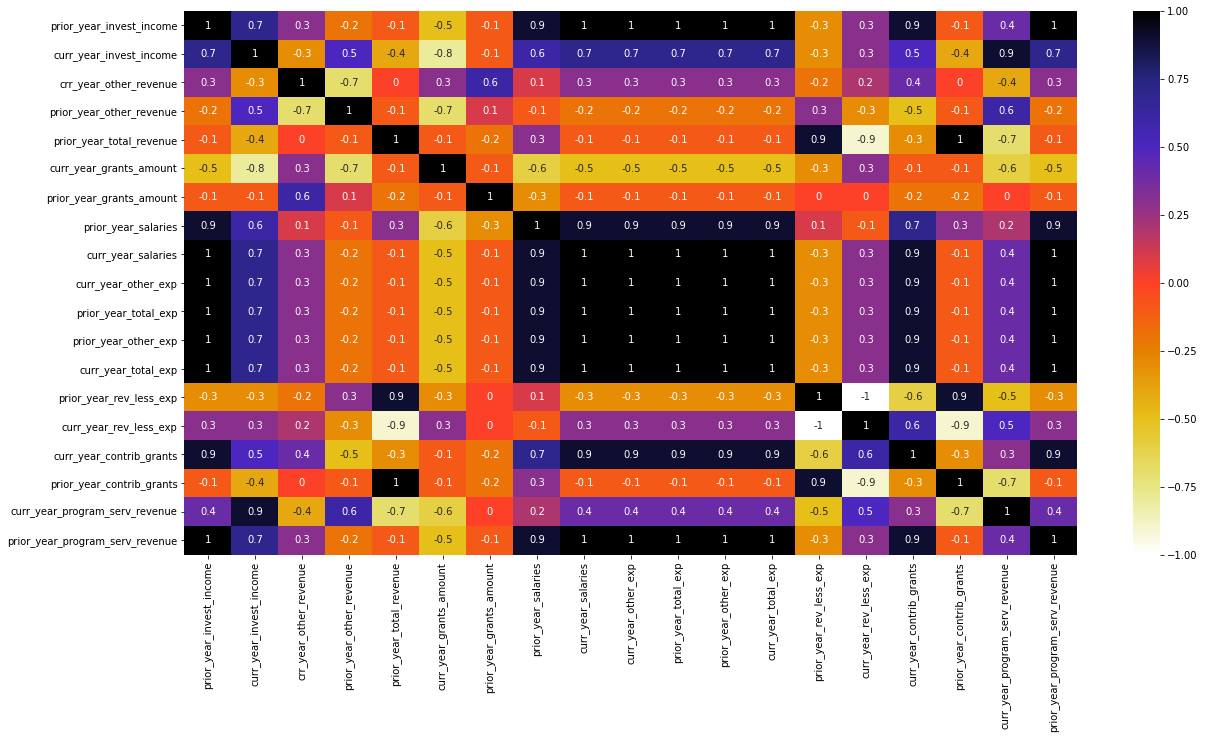

In [0]:
import seaborn as sns

data_corr_list = []
for entity in entities:
    data_corr_list.append(entity['x'].corr(method="spearman"))

plt.figure(figsize = (20,10))

sns.heatmap(data_corr_list[0],annot=True,cmap=plt.cm.CMRmap_r)

plt.show()


In [0]:
data_clean_corr = []

for entity in entities:
    corr_features = correlate(entity['x'], 0.8)
    data_clean_corr.append(entity['x'].drop(corr_features,axis = 1 ).corr())


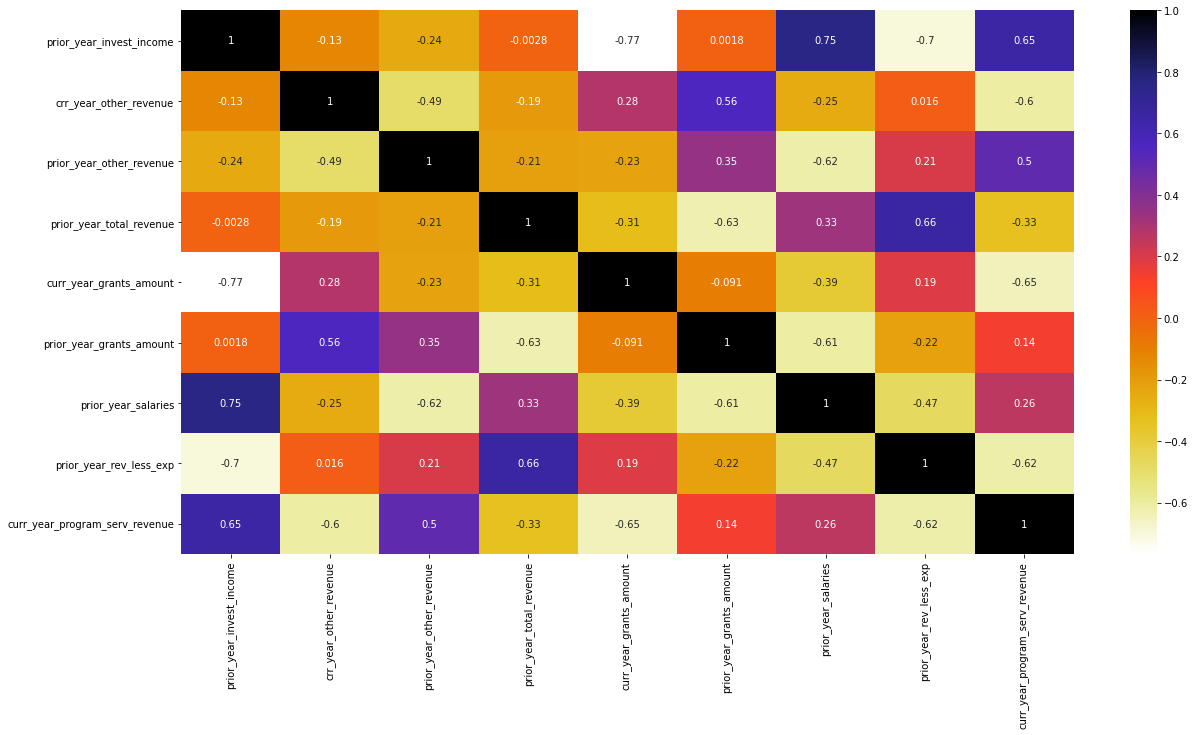

In [0]:
plt.figure(figsize = (20,10))

sns.heatmap(data_clean_corr[0],annot=True,cmap=plt.cm.CMRmap_r)

plt.show()

In [0]:
data_clean_corr[0]

,prior_year_invest_income,crr_year_other_revenue,prior_year_other_revenue,prior_year_total_revenue,curr_year_grants_amount,prior_year_grants_amount,prior_year_salaries,prior_year_rev_less_exp,curr_year_program_serv_revenue
prior_year_invest_income,1.000000,-0.128103,-0.244127,-0.002794,-0.766767,0.001819,0.752273,-0.704262,0.654923
crr_year_other_revenue,-0.128103,1.000000,-0.492048,-0.187777,0.281499,0.558490,-0.251289,0.015765,-0.604473
prior_year_other_revenue,-0.244127,-0.492048,1.000000,-0.214346,-0.225369,0.346539,-0.619819,0.205080,0.498437
prior_year_total_revenue,-0.002794,-0.187777,-0.214346,1.000000,-0.313720,-0.626313,0.327081,0.656172,-0.332304
curr_year_grants_amount,-0.766767,0.281499,-0.225369,-0.313720,1.000000,-0.091313,-0.386751,0.192153,-0.649150
prior_year_grants_amount,0.001819,0.558490,0.346539,-0.626313,-0.091313,1.000000,-0.605119,-0.216321,0.141575
prior_year_salaries,0.752273,-0.251289,-0.619819,0.327081,-0.386751,-0.605119,1.000000,-0.471793,0.259839
prior_year_rev_less_exp,-0.704262,0.015765,0.205080,0.656172,0.192153,-0.216321,-0.471793,1.000000,-0.619994
curr_year_program_serv_revenue,0.654923,-0.604473,0.498437,-0.332304,-0.649150,0.141575,0.259839,-0.619994,1.000000


In [0]:
import warnings
warnings.filterwarnings("ignore")

valid_matrix = []
for index, corr_list in enumerate(data_clean_corr):
    try:
        kmo_all, kmo_model = calculate_kmo(corr_list)
        if kmo_model >= 0.6:
            valid_matrix.append(entities[index])
    except:
            pass
print(len(valid_matrix))

125


In [0]:
#valid_matrix[0]
#dfe = []
#for entity in valid_matrix: 
#    entity['x']['y'] = entity['y']
#    entity['x']['ein'] = entity['ein']
    


## Valores Propios

In [0]:

covariance_matrixes = []

for entity in valid_matrix:
    covariance_matrixes.append(np.dot(entity['x'].T, entity['x']))

In [0]:
determinat_matrixes = []
trace_matrixes = []
eigenvalues_mat = []
eigenvectors_mat = []
for covariance_matrix in covariance_matrixes:
    determinat_matrixes.append(np.linalg.det(covariance_matrix)) 
    trace_matrixes.append(np.trace(covariance_matrix))
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
    eigenvalues_mat.append(eigenvalues)
    eigenvectors_mat.append(eigenvectors)
print('VALORES PROPIOS: ', eigenvalues_mat[0][0])
print('VECTORES PROPIOS: ', eigenvectors_mat[0])
determinat_matrixes[0], trace_matrixes[0]

VALORES PROPIOS:  (39548171332633.9+0j)
VECTORES PROPIOS:  [[-3.45852463e-02+0.00000000e+00j  1.79697450e-01+0.00000000e+00j
   5.53817637e-01+0.00000000e+00j -1.69713960e-01+0.00000000e+00j
   1.88064725e-01+0.00000000e+00j -3.45357711e-01+0.00000000e+00j
  -6.66375802e-02+6.17285273e-02j -6.66375802e-02-6.17285273e-02j
   6.14574508e-02+0.00000000e+00j -1.52075033e-02+5.76508587e-02j
  -1.52075033e-02-5.76508587e-02j -3.24813132e-02-8.86184835e-03j
  -3.24813132e-02+8.86184835e-03j -1.46040912e-02+4.19422361e-03j
  -1.46040912e-02-4.19422361e-03j -5.46697325e-03+0.00000000e+00j
  -1.76384046e-03+1.26610083e-03j -1.76384046e-03-1.26610083e-03j
   3.76174989e-03+0.00000000e+00j]
 [-3.72617366e-02+0.00000000e+00j  5.97671797e-02+0.00000000e+00j
  -2.35338370e-01+0.00000000e+00j -7.49580113e-01+0.00000000e+00j
  -5.09708513e-02+0.00000000e+00j -1.76254308e-01+0.00000000e+00j
   2.42072372e-02-8.02235951e-02j  2.42072372e-02+8.02235951e-02j
  -2.98229895e-02+0.00000000e+00j  1.41511608e-0

In [0]:
print(valid_matrix[0]['x'])
np.linalg.cond(valid_matrix[0]['x'])

      prior_year_invest_income  ...  prior_year_program_serv_revenue
13                       42852  ...                           338196
3151                    128754  ...                           231371
4707                    249937  ...                           238032
5954                     25005  ...                           378577
9055                     41665  ...                           243201

[5 rows x 19 columns]
Out[36]: 56.18196440408392

In [0]:
covariance_matrixes[0]

Out[37]: array([[  83243612639,   51839454671,   -3877037772,   -1032453607,
         611409052194,   30310781096,   31421753091,  374090041823,
         384612953370,  202695600406,  610944229742,  205432434828,
         617619334872,     464822452,  -30551715969,  410816973207,
         405823284902,  128288228797,  123374608260],
       [  51839454671,   86683700214,   -1965389927,    1201794561,
         654035596242,   33639983346,   32985111479,  398993228701,
         405232014373,  218853946033,  649968740232,  217990400052,
         657725943752,    4066856010,   25785994967,  456598596617,
         457975204955,  142195031815,  143019142055],
       [  -3877037772,   -1965389927,     450945617,     192750824,
         -26959023814,   -1486316708,   -1304758681,  -18649750987,
         -18801704414,   -9269608675,  -29555500581,   -9600990913,
         -29557629797,    2596476767,   -3283219445,  -22820571008,
         -18723022695,   -8505833924,   -4551714171],
       [  -10

La matriz esta mal condicionada

## Ledoit and Wolf

In [0]:
from sklearn.covariance import LedoitWolf
conditional_matrix = []
determinant_matrix= []
for covariance_matrix in covariance_matrixes:
    mean_vector = np.zeros(len(covariance_matrix))
    simulated_values = np.random.multivariate_normal(mean_vector, covariance_matrix, 1000)
    df_LedoitWolf = LedoitWolf().fit(simulated_values)
    conditional_matrix.append( np.linalg.cond(df_LedoitWolf.covariance_))
    determinant_matrix.append( np.linalg.det(df_LedoitWolf.covariance_))

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
<command-1883495593028634> in <module>
      8     conditional_matrix.append( np.linalg.cond(df_LedoitWolf.covariance_))
      9     determinant_matrix.append( np.linalg.det(df_LedoitWolf.covariance_))
---> 10 determinant, conditional, ledoit_trace_matrix

NameError: name 'determinant' is not defined

In [0]:
determinant_matrix[0],conditional_matrix[0]

Out[39]: (1.4580125152642365e+192, 8942.511250469865)

# Modelos

## Entrenamiento

In [0]:
from sklearn import model_selection
from sklearn import linear_model
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression

In [0]:
def SSE(residuo):
  return np.sum(residuo**2)

In [0]:
def regresionLineal(X,Y):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, train_size=0.6, random_state=42)
    lin_model = linear_model.LinearRegression()
    lin_model.fit(X_train, y_train)

    residuo_linear = y_train - lin_model.predict(X_train)
    sse_train_lin = SSE(residuo_linear)

    residuo_test = y_test - lin_model.predict(X_test)
    sse_test_lin = SSE(residuo_test)
    return sse_train_lin,sse_test_lin,lin_model.predict(X_train), X_test, y_test

In [0]:
error_lineal_train = []
error_lineal_test = []
lineal_prediccion = []
x_lineal = []
y_lineal = []
eins = []
for entity in valid_matrix:
    error_train, error_test, prediccion,x_test,y_test = regresionLineal(entity['x'],entity['y'])
    error_lineal_train.append(error_train)
    error_lineal_test.append(error_test)
    lineal_prediccion.append(prediccion)
    x_lineal.append(x_test)
    y_lineal.append(y_test)
    eins.append(entity['ein'])
lineal_prediccion[0]

Out[69]: array([1080047., 1275312., 1216653.])

In [0]:
x_lineal[0]

,prior_year_invest_income,curr_year_invest_income,crr_year_other_revenue,prior_year_other_revenue,prior_year_total_revenue,curr_year_grants_amount,prior_year_grants_amount,prior_year_salaries,curr_year_salaries,curr_year_other_exp,prior_year_total_exp,prior_year_other_exp,curr_year_total_exp,prior_year_rev_less_exp,curr_year_rev_less_exp,curr_year_contrib_grants,prior_year_contrib_grants,curr_year_program_serv_revenue,prior_year_program_serv_revenue
3151,128754,249937,-6677,8158,1275312,67534,55523,756035,770386,429429,1214761,403203,1267349,60551,311,786368,907029,238032,231371
9055,41665,63760,-14632,-11150,1080047,62577,59162,807373,797741,380098,1281597,415062,1240416,-201550,411703,1159347,806331,443644,243201


In [0]:
np.array(y_lineal[0])

Out[116]: array([1267660, 1652119])

In [0]:
lineal_prediccion[0]

Out[100]: array([1080047., 1275312., 1216653.])

In [0]:
def regresionLasso(X,Y):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, train_size=0.6, random_state=42)
    lasso_model = linear_model.Lasso(alpha= 1.5)
    lasso_model.fit(X_train, y_train)

    residuo_train_lasso = y_train - lasso_model.predict(X_train)
    sse_train_lasso = SSE(residuo_train_lasso)

    residuo_test_lasso = y_test - lasso_model.predict(X_test)
    sse_test_lasso = SSE(residuo_test_lasso)
    return sse_train_lasso,sse_test_lasso,lasso_model.predict(X_train)

In [0]:
error_lasso_train = []
error_lasso_test = []
error_lasso_prediccion = []
for entity in valid_matrix:
    error_train, error_test, prediccion = regresionLasso(entity['x'],entity['y'])
    error_lasso_train.append(error_train)
    error_lasso_test.append(error_test)
    error_lasso_prediccion.append(prediccion)
error_lineal_prediccion[0]

Out[62]: array([1080047., 1275312., 1216653.])

In [0]:
error_lasso_test[0]

Out[66]: 124643988056.70541